### 1. Load data

In [4]:
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=6)

setwd("/Volumes/GoogleDrive/Shared drives/Influx/Stations_Gradients_2019")

unstained <- FALSE # TRUE if samples were not stained, TRUE if samples have been stained

if(unstained){
    summary <- read_csv("./unstained/summary.csv")
}else{
    stained_summary_all <- read_csv("./stained/summary.csv") # load summary data
    stained_summary <- dplyr::filter(stained_summary_all, stained_summary_all$population == "bacteria")
    unstained_summary <- read_csv("./unstained/summary.csv")}

meta <- read_csv("metadata.txt",col_types = cols(date = col_character())) 

Parsed with column specification:
cols(
  population = col_character(),
  count = col_double(),
  scatter = col_double(),
  red = col_double(),
  orange = col_double(),
  file = col_character()
)

Parsed with column specification:
cols(
  population = col_character(),
  count = col_double(),
  scatter = col_double(),
  red = col_double(),
  orange = col_double(),
  file = col_character()
)



### 2. Convert metadata

In [5]:
meta[1:3,] # print the first few lines to know how to parse metadata

date,old file name,file,station,lat,lon,depth,replicate,run time,volume,stain,flag,comments
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2019-04-13T03:36:52,station_027,station_027,2,31.09083,-157.999,15,A,4,152,0,0,NA
2019-04-13T03:36:52,station_028,station_028,2,31.09083,-157.999,15,B,4,152,0,0,NA
2019-04-13T03:36:52,station_029,station_029,2,31.09083,-157.999,15,C,4,153,0,0,NA


In [6]:
# add required columns (filename, volume and comments) from metadata
file <- paste0(meta$file,".fcs") # format  sample name to filename (.fcs)
time <- meta$date
lat <- meta$lat
lon <- meta$lon
depth <- meta$depth
replicate <- meta$replicate
volume <- meta$volume
stain <- meta$stain
flag <- meta$flag
comments <- meta$comments

# add required metadata for CMAP
# time <- as.POSIXct(meta$date, format="%d/%b/%y", tz="UTC") 
# lat <- NA
# lon <- NA

# add key information from sample label
# label <- matrix(unlist(list(strsplit(meta$label, split=" "))), ncol=3, byrow=T) 
# treatment <- label[,1]
# timepoint <- label[,2]
# replicate <- label[,3]

# create new metadata
metadata <- tibble(file, time, lat, lon, depth, replicate, volume, stain, flag, comments)

### 3. Merge files
#### a. Merge unstained and unstained summary data

In [7]:
if(unstained == FALSE){
  summary <- merge(unstained_summary, stained_summary, all=TRUE)
  summary[1:3,]
}

,population,count,scatter,red,orange,file
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,bacteria,4,0.001224,0.048843,0.026439,sybr_rerun_036.fcs
2,bacteria,15,0.001234,0.070880,0.042977,sybr_036.fcs
3,bacteria,27956,0.000983,0.028413,0.011338,sybr_006.fcs


#### b. Add metadata to summary data

In [8]:
all <- merge(summary, metadata, by="file")
all[1:3,]
all$abundance <- all$count / all$volume

,file,population,count,scatter,red,orange,time,lat,lon,depth,replicate,volume,stain,flag,comments
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,station_001.fcs,picoeuk,4692,1.033142,3.621333,0.000750,2019-04-25T12:14:16,42.33367,-157.9993,25,A,191,0,0,NA
2,station_001.fcs,unknown,110656,0.003502,0.001726,0.000594,2019-04-25T12:14:16,42.33367,-157.9993,25,A,191,0,0,NA
3,station_001.fcs,synecho,2172,0.087379,0.883109,0.202074,2019-04-25T12:14:16,42.33367,-157.9993,25,A,191,0,0,NA


### 4. Calculate abundance
#### a. Check abundance

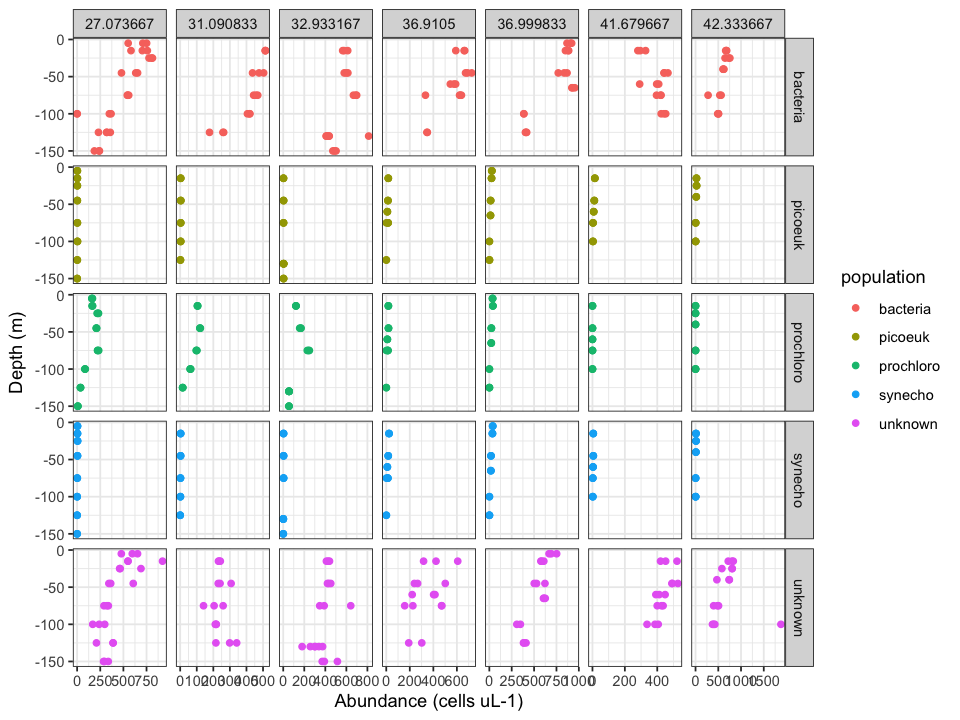

In [9]:
all %>%
    dplyr::filter(population != "beads") %>%
    ggplot(aes(abundance, -depth, col=population)) + 
    geom_point() + 
    facet_grid(population ~ lat, scale="free_x") + 
    theme_bw() +
    xlab("Abundance (cells uL-1)") + 
    ylab("Depth (m)")

#### b. Calculate bacteria abundance

In [19]:
new.all <- all

if(unstained == FALSE){

  pro <- subset(all, population == "prochloro")
  bact <- subset(all, population == "bacteria")

  for (i in 1:nrow(pro)){
    file_number <- regmatches(pro$file[i], regexpr(pattern = "[0-9].*fcs" , text = pro$file[i]))  # removes prefix from the current file so the stained and unstained files will be identical
    matching_file_id <- grep(file_number, bact$file) # find the file in stained samples that matches the file number
    id <- which(all$file == bact$file[matching_file_id] & all$population == "bacteria") # return the index of the file that matches the Pro file numbner
    if(length(id) !=0) new.all$abundance[id] <- all$abundance[id] - pro$abundance[i]
  }
}

new.all[1:3,]

Warning message in all$file == bact$file[matching_file_id]:
"longer object length is not a multiple of shorter object length"
Warning message in all$file == bact$file[matching_file_id]:
"longer object length is not a multiple of shorter object length"


,file,population,count,scatter,red,orange,time,lat,lon,depth,replicate,volume,stain,flag,comments,abundance
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,station_001.fcs,picoeuk,4692,1.033142,3.621333,0.000750,2019-04-25T12:14:16,42.33367,-157.9993,25,A,191,0,0,NA,24.56545
2,station_001.fcs,unknown,110656,0.003502,0.001726,0.000594,2019-04-25T12:14:16,42.33367,-157.9993,25,A,191,0,0,NA,579.35079
3,station_001.fcs,synecho,2172,0.087379,0.883109,0.202074,2019-04-25T12:14:16,42.33367,-157.9993,25,A,191,0,0,NA,11.37173


#### c. Check new abundance

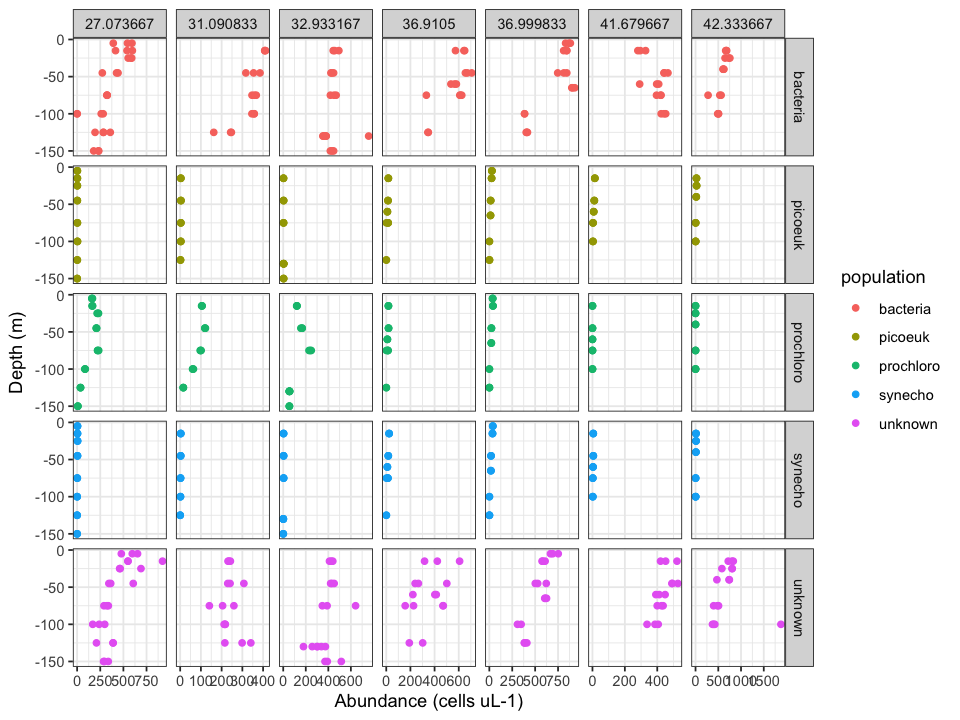

In [20]:
new.all %>%
    dplyr::filter(population != "beads") %>%
    ggplot(aes(abundance, -depth, col=population)) + 
    geom_point() + 
    facet_grid(population ~ lat, scale="free_x") + 
    theme_bw() +
    xlab("Abundance (cells uL-1)") + 
    ylab("Depth (m)")

### 5. Plotting
#### a. Surface abundance

`summarise()` regrouping output by 'lat' (override with `.groups` argument)



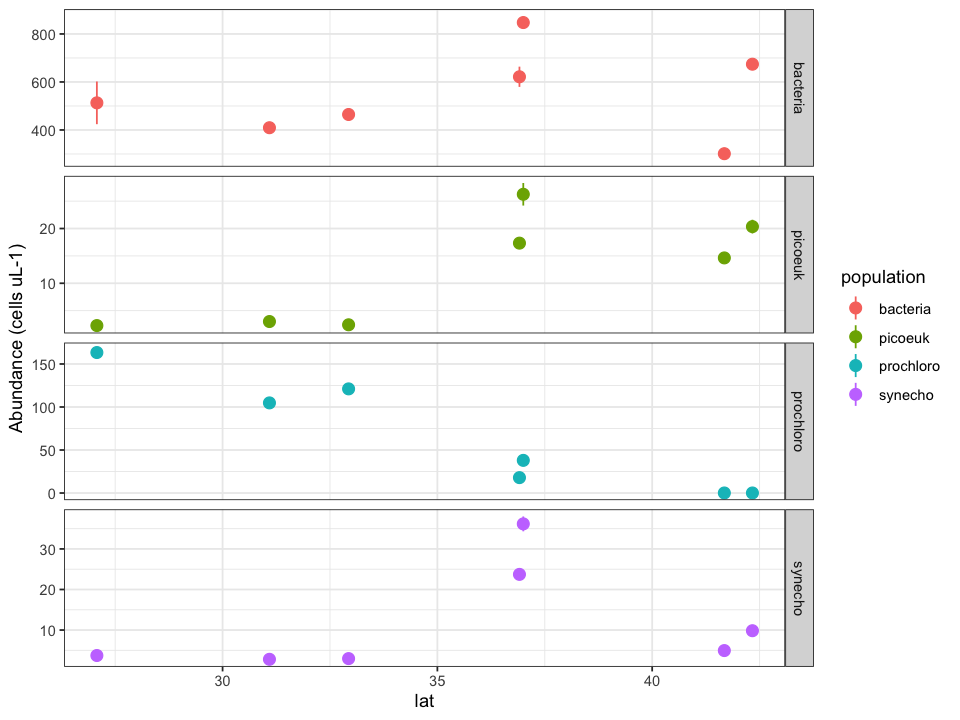

In [23]:
new.all %>%
    dplyr::filter(population != "beads" & population != "unknown" & depth < 20) %>%
    group_by(lat, population) %>%
    summarize(sd = sd(abundance),
              avg=mean(abundance)) %>%
    ggplot(aes(lat, avg, col=population)) +
    geom_point(size=3) +
    geom_linerange(aes(ymin=avg-sd, ymax=avg+sd)) +
    facet_grid(population ~ ., scale="free_y") + 
    theme_bw() +
    ylab("Abundance (cells uL-1)")

#### b. Abundance depth profile

`summarise()` regrouping output by 'lat', 'depth' (override with `.groups` argument)



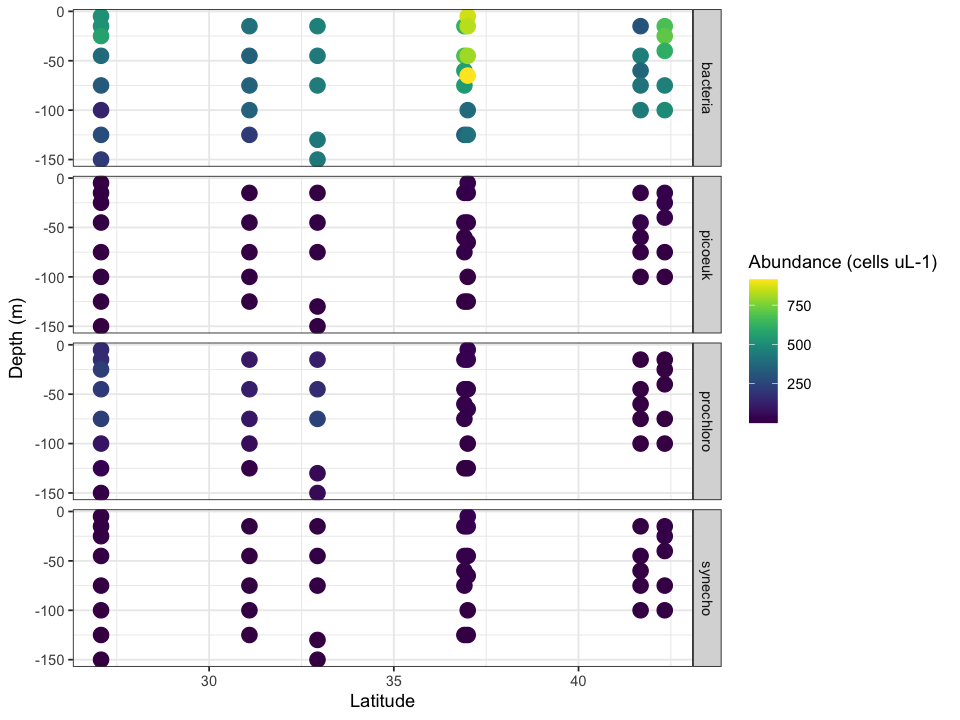

In [27]:
new.all %>%
    dplyr::filter(population != "beads" & population != "unknown") %>%
    group_by(lat, depth, population) %>%
    summarize(avg=mean(abundance)) %>%
    ggplot(aes(lat, -depth)) + 
    geom_point(aes(colour=avg), size=4) + 
    scale_colour_viridis(name="Abundance (cells uL-1)",option ="D") +
    facet_grid(population ~ .) + 
    theme_bw() +
    xlab("Latitude") + 
    ylab("Depth (m)")

#### c. Scatter depth profile

`summarise()` regrouping output by 'lat', 'depth' (override with `.groups` argument)



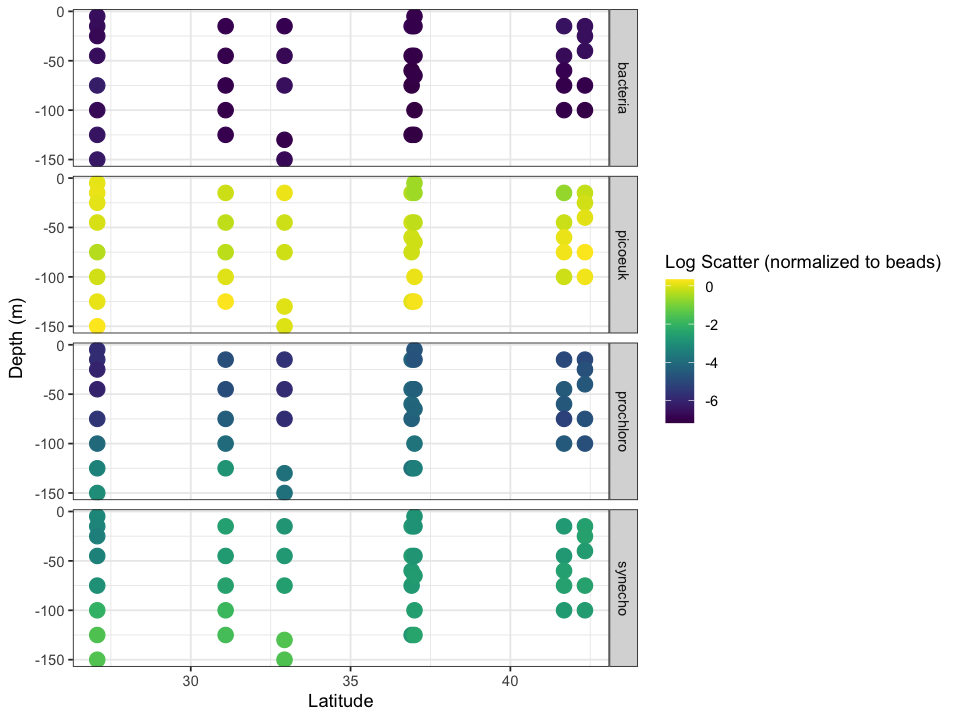

In [28]:
new.all %>%
    dplyr::filter(population != "beads" & population != "unknown") %>%
    group_by(lat, depth, population) %>%
    summarize(avg=log(mean(scatter))) %>%
    ggplot(aes(lat, -depth)) + 
    geom_point(aes(colour=avg), size=4) + 
    scale_colour_viridis(name="Log Scatter (normalized to beads)",option ="D") +
    facet_grid(population ~ .) + 
    theme_bw() +
    xlab("Latitude") + 
    ylab("Depth (m)")

#### d. Red fluorescence depth profile

`summarise()` regrouping output by 'lat', 'depth' (override with `.groups` argument)



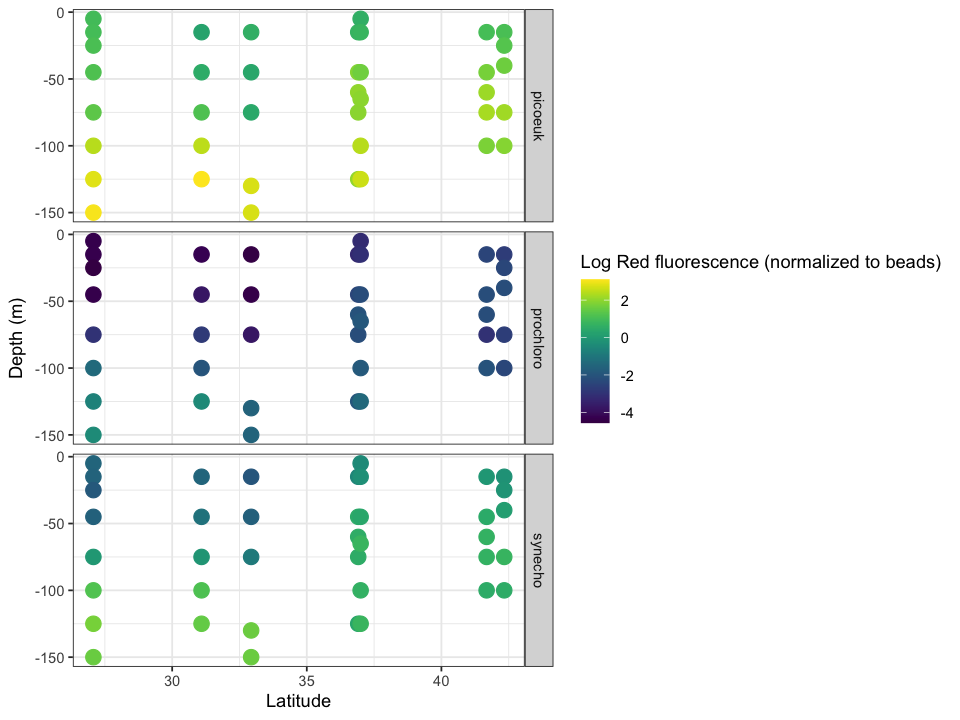

In [29]:
new.all %>%
    dplyr::filter(population != "beads" & population != "unknown" & population != "bacteria") %>%
    group_by(lat, depth, population) %>%
    summarize(avg=log(mean(red))) %>%
    ggplot(aes(lat, -depth)) + 
    geom_point(aes(colour=avg), size=4) + 
    scale_colour_viridis(name="Log Red fluorescence (normalized to beads)",option ="D") +
    facet_grid(population ~ .) + 
    theme_bw() +
    xlab("Latitude") + 
    ylab("Depth (m)")

### 6. Save data

In [15]:
library(FCSplankton)
library(openxlsx)

project <- basename(getwd())
cruise <- "MGL1704" # Cruise ID (ex. KM1906); leave blank if samples were not collected during a cruise

cmap_convert(data = new.all , cruise, project, unstained=FALSE, version = "v1.0")

Loading required package: flowCore

Warning message in .getGeneric(f, where, package):
"strings not representable in native encoding will be translated to UTF-8"
Loading required package: splancs

Loading required package: sp


Spatial Point Pattern Analysis Code in S-Plus
 
 Version 2 - Spatial and Space-Time analysis



Attaching package: 'splancs'


The following object is masked from 'package:dplyr':

    tribble


The following object is masked from 'package:tidyr':

    tribble


The following object is masked from 'package:tibble':

    tribble


Loading required package: viridis

Loading required package: viridisLite

Warning message in eval_tidy(xs[[j]], mask):
"strings not representable in native encoding will be translated to UTF-8"
